### Task: 
You have to build an **Automatic higher or lower game**. Refer to the diagram below.

Set the bounds to between 1 to 20. The graph has to keep guessing (***The maximum guesses is 7***) where if the guest is correct, then it stops, but if not we keep looping until we hit the maximum limit of 7.

Each time a number is guessed, the **hint node** should say `higher` or `lower` and the graph should continue for this information and guess the next guess accordingly.

**Input** : `{"player_name" : "Ravish", "guesses" = [], "attempts" : [], "low_bound" : 1, "upper_bound" : 20}`

***Hint*** : It will need to adjust its bound after every guess based on the hint provided by the **hint node**

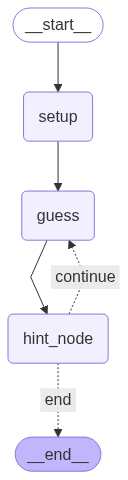

In [1]:
from typing import List, TypedDict
from langgraph.graph import StateGraph, END
import random

In [2]:
class AgentState(TypedDict):
    player_name: str
    guesses: List[int]
    attempts: int
    low_bound: int
    upper_bound: int
    target : int
    hint : str


In [3]:
def setup_node(state: AgentState) -> AgentState:
    state['player_name'] = f"Hi {state['player_name']}, Let's play!"
    state['target'] = random.randint(1, 20)
    state['guesses'] = []
    state['attempts'] = 0
    state['low_bound'] = 1
    state['upper_bound'] = 20
    state['hint'] = "Game started! Try to guess the number!"

    print(f"{state['player_name']}, the game has begun. The number is between 1 to 20")
    return state


In [4]:
def guess_node(state: AgentState) -> AgentState:
    """ This state will guess the target number """
    possible_guesses = [i for i in range(state["low_bound"], state["upper_bound"] + 1) if i not in state["guesses"]]
    if possible_guesses:
        guess = random.choice(possible_guesses)
    else:
        
        guess = random.randint(state["low_bound"], state["upper_bound"])
    
    state["guesses"].append(guess)
    state["attempts"] += 1
    print(f"Attempt {state['attempts']}: Guessing {guess} (Current range: {state['low_bound']}-{state['upper_bound']})")
    return state

In [5]:
def hint_node(state: AgentState) -> AgentState:
    """Here we provide a hint based on the last guess and update the bounds"""
    latest_guess = state["guesses"][-1]
    target = state["target"]
    
    if latest_guess < target:
        state["hint"] = f"The number {latest_guess} is too low. Try higher!"
        
        state["low_bound"] = max(state["low_bound"], latest_guess + 1)
        print(f"Hint: {state['hint']}")
        
    elif latest_guess > target:
        state["hint"] = f"The number {latest_guess} is too high. Try lower!"
      
        state["upper_bound"] = min(state["upper_bound"], latest_guess - 1)
        print(f"Hint: {state['hint']}")
    else:
        state["hint"] = f"Correct! You found the number {target} in {state['attempts']} attempts."
        print(f"Success! {state['hint']}")
    
    return state

In [6]:
def should_continue(state: AgentState) -> str:
    """Determine if we should continue guessing or end the game"""
    
    # There are 2 end conditions - either 7 is reached or the correct number is guessed
    
    latest_guess = state["guesses"][-1]
    if latest_guess == state["target"]:
        print(f"GAME OVER: Number found!")
        return "end"
    elif state["attempts"] >= 7:
        print(f"GAME OVER: Maximum attempts reached! The number was {state['target']}")
        return "end"
    else:
        print(f"CONTINUING: {state['attempts']}/7 attempts used")
        return "continue"

In [7]:
graph = StateGraph(AgentState)
graph.add_node("setup", setup_node)
graph.add_node("guess", guess_node)
graph.add_node("hint_node", hint_node)  


graph.add_edge("setup", "guess")
graph.add_edge("guess", "hint_node")  


graph.add_conditional_edges(
    "hint_node", 
    should_continue,
    {
        "continue": "guess",
        "end": END
    }
)

graph.set_entry_point("setup")
app = graph.compile()

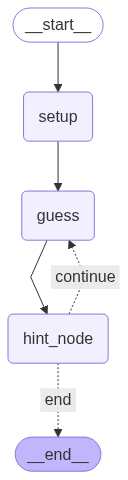

In [8]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [9]:
result = app.invoke({"player_name": "Ravish", "guesses": [], "attempts": 0, "low_bound": 1, "upper_bound": 20})

Hi Ravish, Let's play!, the game has begun. The number is between 1 to 20
Attempt 1: Guessing 6 (Current range: 1-20)
Hint: The number 6 is too low. Try higher!
CONTINUING: 1/7 attempts used
Attempt 2: Guessing 12 (Current range: 7-20)
Hint: The number 12 is too low. Try higher!
CONTINUING: 2/7 attempts used
Attempt 3: Guessing 15 (Current range: 13-20)
Hint: The number 15 is too high. Try lower!
CONTINUING: 3/7 attempts used
Attempt 4: Guessing 13 (Current range: 13-14)
Hint: The number 13 is too low. Try higher!
CONTINUING: 4/7 attempts used
Attempt 5: Guessing 14 (Current range: 14-14)
Success! Correct! You found the number 14 in 5 attempts.
GAME OVER: Number found!
